# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import rich
from scipy.optimize import minimize
from tqdm.auto import tqdm

# Main

## 1. Подготовка данных

In [4]:
df = pd.read_excel("stocks.xlsx", index_col=0).reset_index().drop('index', axis=1).set_index('date')
df = df.select_dtypes(['datetime', 'float'])
assert df.isna().sum().sum() == 0

df.head()

RASP   RBCM   RENI    RGSS   RDRB  ROST    ROSN     MRKV  LSNG  \
date                                                                           
2023-01-03  231.25  2.594  50.00  0.1828  156.0  57.6  368.05  0.02645  8.78   
2023-01-04  230.25  2.592  49.90  0.1790  174.0  57.6  365.80  0.02665  8.67   
2023-01-05  229.85  2.592  50.06  0.1790  180.0  57.4  367.50  0.02705  8.52   
2023-01-06  226.25  2.586  50.14  0.1772  178.0  56.8  367.30  0.02675  8.48   
2023-01-09  224.80  2.650  51.14  0.1790  188.0  57.6  367.95  0.02720  8.57   

              MSRS  ...    SIBN    GAZP    SMLT   LSRG    POSI    GCHE   GTRK  \
date                ...                                                         
2023-01-03  1.0060  ...  456.90  163.52  2424.5  475.4  1288.6  2744.0  51.75   
2023-01-04  1.0010  ...  456.20  162.51  2428.0  474.0  1288.4  2799.5  62.05   
2023-01-05  0.9325  ...  455.00  161.20  2397.5  470.4  1276.6  2774.5  60.80   
2023-01-06  0.9235  ...  454.55  162.10  2390.0  465.8  1259.6  2760.0  58.75   
2023-01-09  0.9305  ...  454.65  162.71  2395.0  471.2  1286.8  2768.0  57.80   

             FESH  DIOD   DVEC  
date                            
2023-01-03  34.23  7.76  0.958  
2023-01-04  34.09  7.89  0.957  
2023-01-05  33.87  7.85  0.981  
2023-01-06  33.91  7.87  1.015  
2023-01-09  34.92  7.94  1.355  

[5 rows x 125 columns]

In [5]:
# Тут считаем как у Расохина - прирост к цене от начала периода до конца периода
total_return = (df.iloc[-1] - df.iloc[0]) / df.iloc[0]

# Можно вывести графики (временные ряды) наиболее доходных

total_return

RASP   -0.259676
RBCM    3.377409
RENI    0.876800
RGSS    0.170678
RDRB   -0.201923
          ...   
GCHE    0.295918
GTRK    2.130435
FESH    0.601811
DIOD    0.493557
DVEC    1.054280
Length: 125, dtype: float64

In [6]:
daily_return = df.pct_change().dropna()
daily_return.head()

RASP      RBCM      RENI      RGSS      RDRB      ROST  \
date                                                                     
2023-01-04 -0.004324 -0.000771 -0.002000 -0.020788  0.115385  0.000000   
2023-01-05 -0.001737  0.000000  0.003206  0.000000  0.034483 -0.003472   
2023-01-06 -0.015662 -0.002315  0.001598 -0.010056 -0.011111 -0.010453   
2023-01-09 -0.006409  0.024749  0.019944  0.010158  0.056180  0.014085   
2023-01-10 -0.000445  0.104151  0.013297  0.016760 -0.010638  0.000000   

                ROSN      MRKV      LSNG      MSRS  ...      SIBN      GAZP  \
date                                                ...                       
2023-01-04 -0.006113  0.007561 -0.012528 -0.004970  ... -0.001532 -0.006177   
2023-01-05  0.004647  0.015009 -0.017301 -0.068432  ... -0.002630 -0.008061   
2023-01-06 -0.000544 -0.011091 -0.004695 -0.009651  ... -0.000989  0.005583   
2023-01-09  0.001770  0.016822  0.010613  0.007580  ...  0.000220  0.003763   
2023-01-10 -0.003261 -0.001838  0.003501  0.000537  ... -0.000330 -0.003749   

                SMLT      LSRG      POSI      GCHE      GTRK      FESH  \
date                                                                     
2023-01-04  0.001444 -0.002945 -0.000155  0.020226  0.199034 -0.004090   
2023-01-05 -0.012562 -0.007595 -0.009159 -0.008930 -0.020145 -0.006454   
2023-01-06 -0.003128 -0.009779 -0.013317 -0.005226 -0.033717  0.001181   
2023-01-09  0.002092  0.011593  0.021594  0.002899 -0.016170  0.029785   
2023-01-10  0.004802  0.003396 -0.004196 -0.001626 -0.008651  0.006586   

                DIOD      DVEC  
date                            
2023-01-04  0.016753 -0.001044  
2023-01-05 -0.005070  0.025078  
2023-01-06  0.002548  0.034659  
2023-01-09  0.008895  0.334975  
2023-01-10 -0.006297 -0.037638  

[5 rows x 125 columns]

In [7]:
# Можно вывести графики наиболее волатильных и наименее волатильных
risk = daily_return.std()
risk

RASP    0.020981
RBCM    0.039738
RENI    0.020927
RGSS    0.031704
RDRB    0.024430
          ...   
GCHE    0.018087
GTRK    0.063206
FESH    0.032359
DIOD    0.030807
DVEC    0.035261
Length: 125, dtype: float64

In [8]:
cov_matrix = daily_return.cov()
corr_matrix = daily_return.corr()

cov_matrix

RASP      RBCM      RENI      RGSS      RDRB      ROST      ROSN  \
RASP  0.000440  0.000200  0.000169  0.000132  0.000086  0.000114  0.000165   
RBCM  0.000200  0.001579  0.000199  0.000276  0.000142  0.000142  0.000155   
RENI  0.000169  0.000199  0.000438  0.000127  0.000078  0.000084  0.000126   
RGSS  0.000132  0.000276  0.000127  0.001005  0.000098  0.000148  0.000077   
RDRB  0.000086  0.000142  0.000078  0.000098  0.000597  0.000132  0.000077   
...        ...       ...       ...       ...       ...       ...       ...   
GCHE  0.000107  0.000216  0.000120  0.000106  0.000107  0.000064  0.000083   
GTRK  0.000258  0.000461  0.000277  0.000422  0.000172  0.000143  0.000273   
FESH  0.000276  0.000279  0.000215  0.000145  0.000136  0.000149  0.000252   
DIOD  0.000084  0.000228  0.000148  0.000222  0.000115  0.000214  0.000098   
DVEC  0.000155  0.000323  0.000178  0.000251  0.000145  0.000264  0.000135   

          MRKV      LSNG      MSRS  ...      SIBN      GAZP      SMLT  \
RASP  0.000127  0.000170  0.000123  ...  0.000158  0.000192  0.000259   
RBCM  0.000268  0.000304  0.000189  ...  0.000160  0.000177  0.000264   
RENI  0.000144  0.000142  0.000125  ...  0.000114  0.000145  0.000188   
RGSS  0.000113  0.000225  0.000109  ...  0.000078  0.000112  0.000135   
RDRB  0.000101  0.000198  0.000062  ...  0.000058  0.000083  0.000137   
...        ...       ...       ...  ...       ...       ...       ...   
GCHE  0.000105  0.000161  0.000104  ...  0.000084  0.000103  0.000136   
GTRK  0.000189  0.000327  0.000193  ...  0.000247  0.000276  0.000414   
FESH  0.000189  0.000248  0.000168  ...  0.000213  0.000274  0.000386   
DIOD  0.000175  0.000299  0.000151  ...  0.000116  0.000122  0.000146   
DVEC  0.000272  0.000363  0.000258  ...  0.000105  0.000163  0.000202   

          LSRG      POSI      GCHE      GTRK      FESH      DIOD      DVEC  
RASP  0.000162  0.000161  0.000107  0.000258  0.000276  0.000084  0.000155  
RBCM  0.000257  0.000203  0.000216  0.000461  0.000279  0.000228  0.000323  
RENI  0.000143  0.000149  0.000120  0.000277  0.000215  0.000148  0.000178  
RGSS  0.000116  0.000105  0.000106  0.000422  0.000145  0.000222  0.000251  
RDRB  0.000109  0.000114  0.000107  0.000172  0.000136  0.000115  0.000145  
...        ...       ...       ...       ...       ...       ...       ...  
GCHE  0.000128  0.000100  0.000327  0.000213  0.000142  0.000132  0.000156  
GTRK  0.000288  0.000298  0.000213  0.003995  0.000500  0.000697  0.000524  
FESH  0.000237  0.000247  0.000142  0.000500  0.001047  0.000204  0.000263  
DIOD  0.000167  0.000099  0.000132  0.000697  0.000204  0.000949  0.000289  
DVEC  0.000219  0.000205  0.000156  0.000524  0.000263  0.000289  0.001243  

[125 rows x 125 columns]

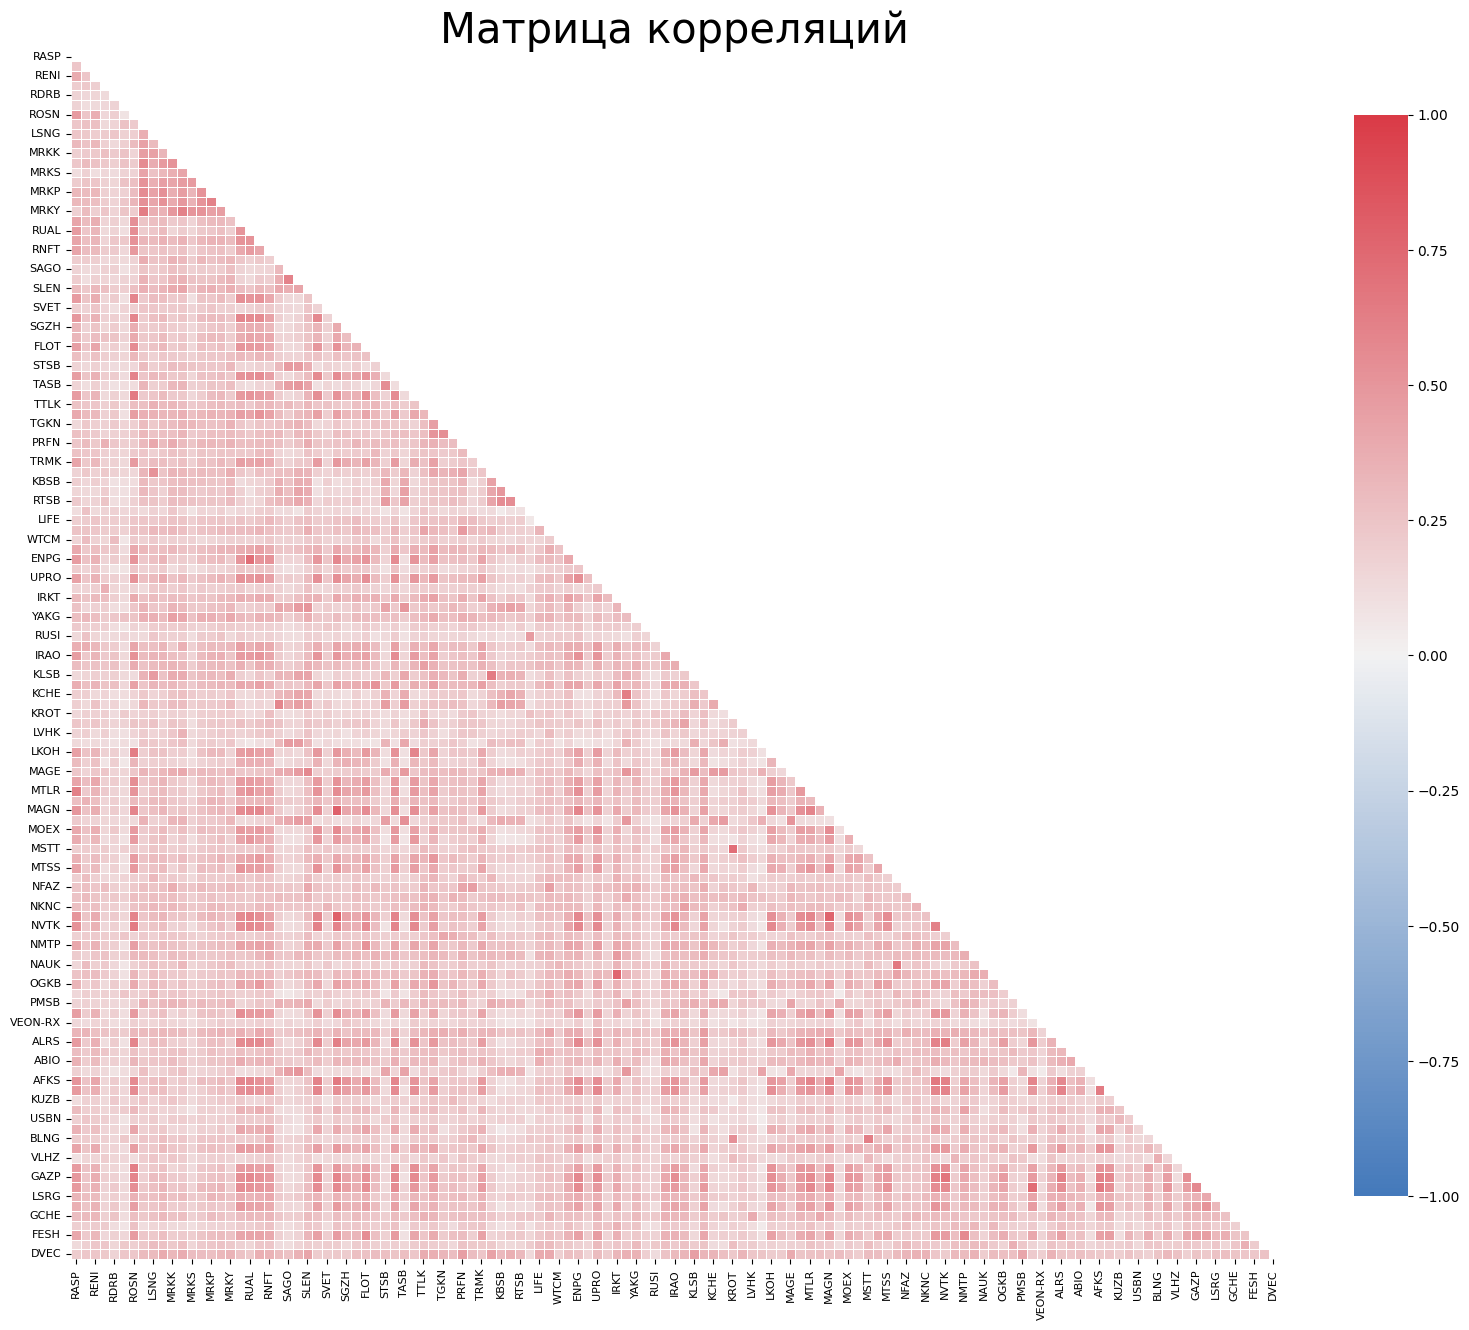

In [9]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=sns.diverging_palette(250, 10, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title("Матрица корреляций", fontsize=30)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig("images/picture_1.png", dpi=400)
plt.show()

## 2. Выбор акций в портфель [минимальное остовное дерево]

In [11]:
# Вводим меру расстояния для двух котировок

alpha = 0.7
distance_matrix = alpha * (2 - np.sqrt(2 * (1 - corr_matrix)))
n = len(df.columns)
for i in range(n):
    for j in range(n):
        return_i = total_return.iloc[i]
        return_j = total_return.iloc[j]
        distance_matrix.iloc[i, j] += (1 - alpha) * np.abs(return_i - return_j)
            

# Тут чем выше корреляция активов, тем менее похожи эти активы между собой
# Чем более близки доходности активов, тем ближи эти активы между собой

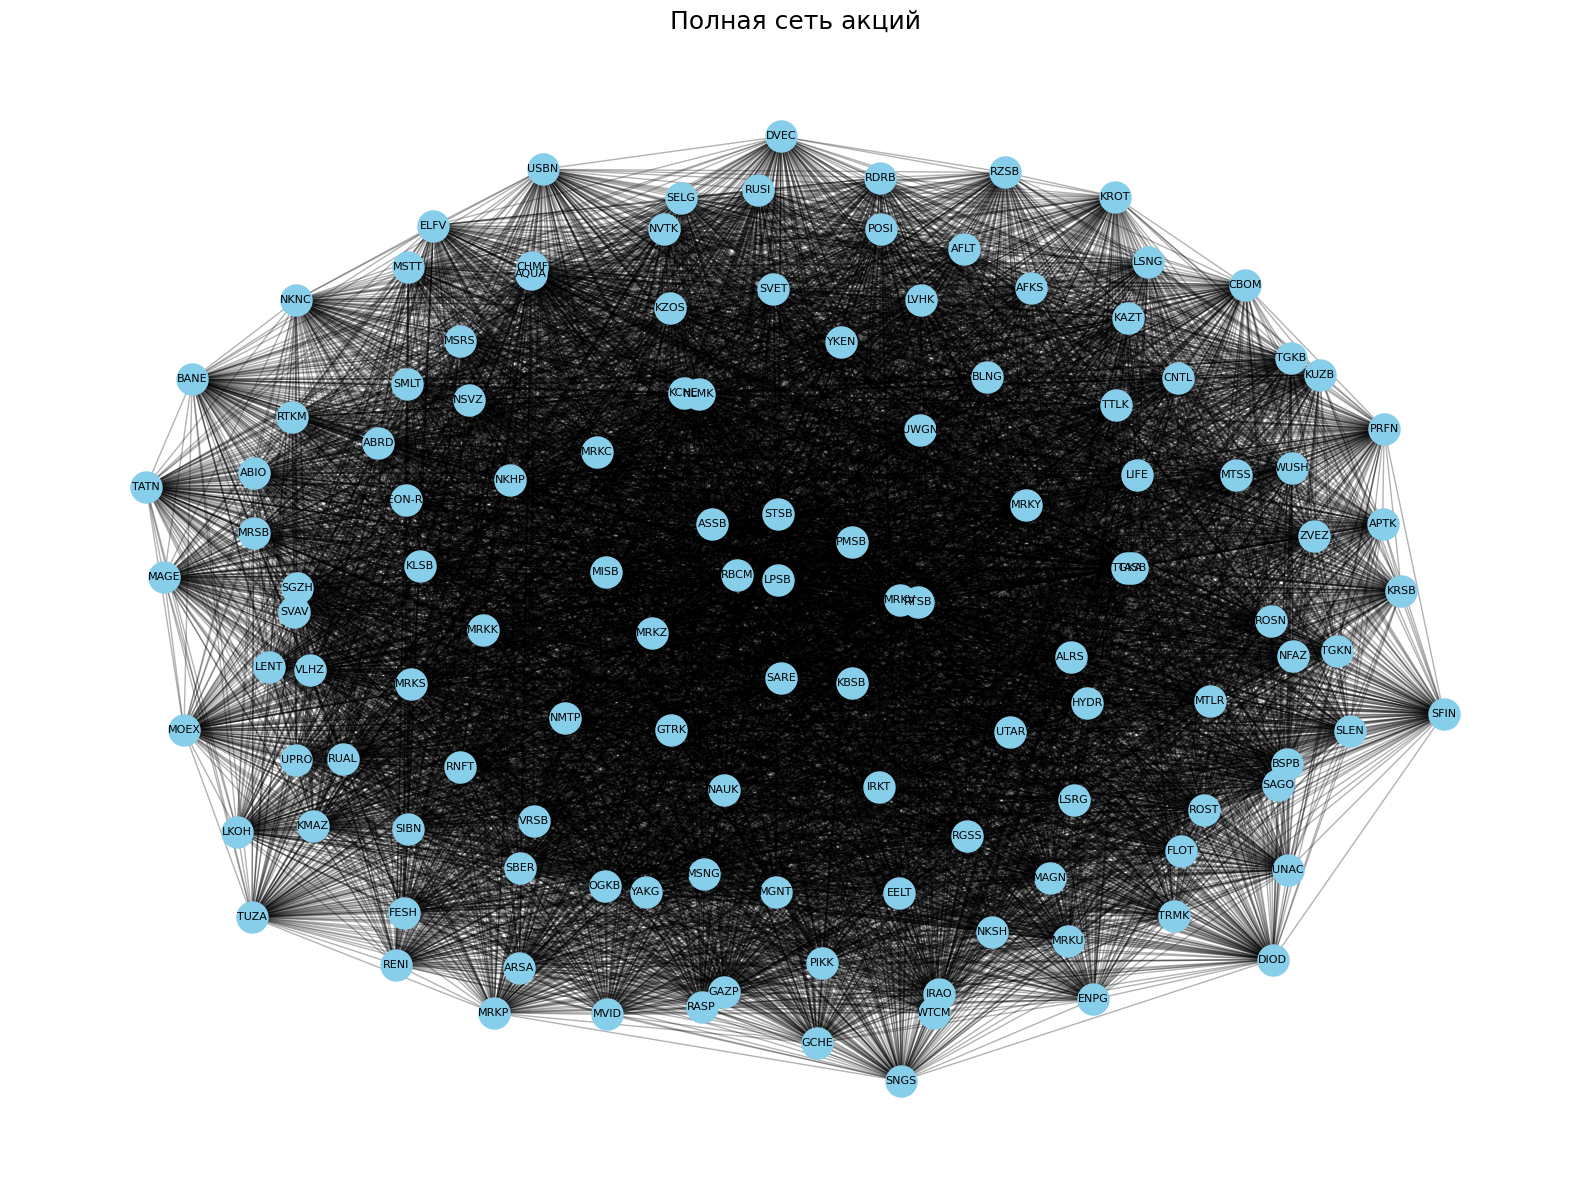

In [13]:
# Строим полную сеть

G = nx.Graph()

for i in distance_matrix.columns:
    for j in distance_matrix.columns:
        if i != j:
            G.add_edge(i, j, weight=distance_matrix.loc[i, j])

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Полная сеть акций", fontsize=18)
plt.axis("off")
plt.tight_layout()
plt.savefig("images/picture_2.png", dpi=400)
plt.show()

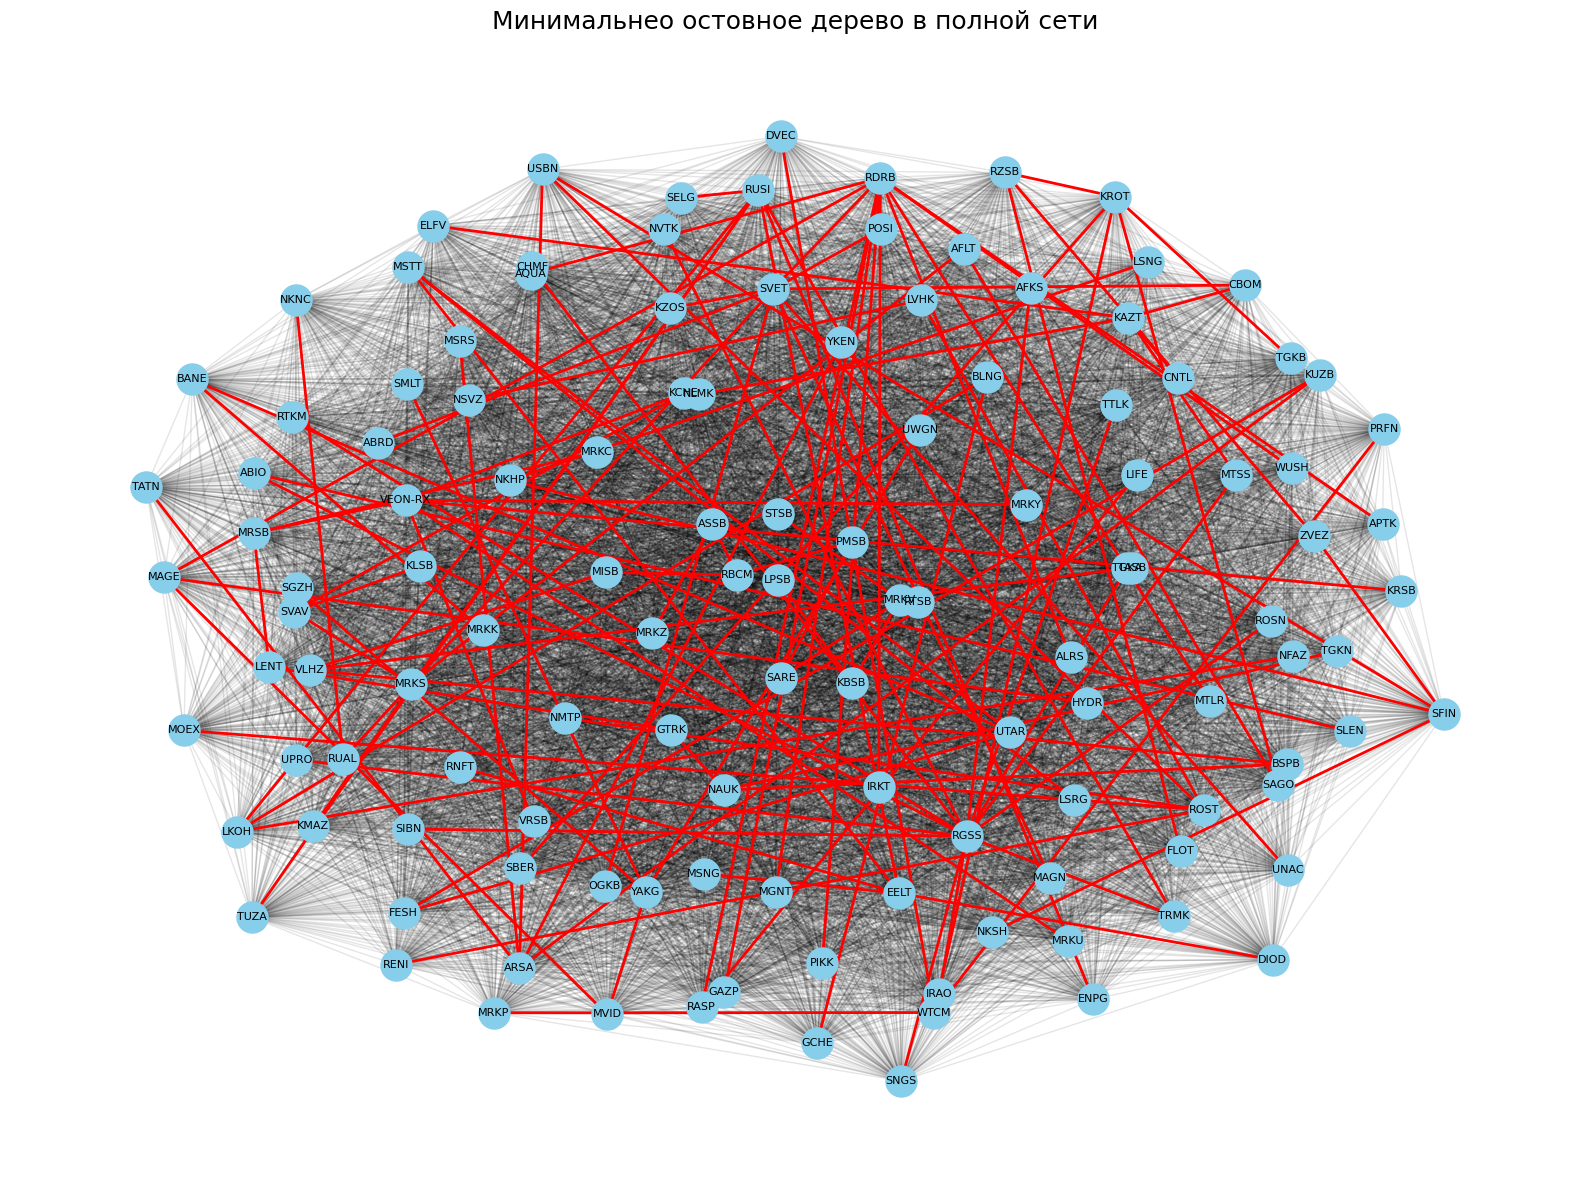

In [21]:
# Выделяем минимальное остовное дерево

mst = nx.minimum_spanning_tree(G)

plt.figure(figsize=(16, 12))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')

nx.draw_networkx_edges(G, pos, alpha=0.1)

nx.draw_networkx_edges(mst, pos, edge_color='red', width=2)

nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Минимальнео остовное дерево в полной сети", fontsize=18)
plt.axis("off")
plt.tight_layout()
plt.savefig("images/picture_3.png", dpi=400)
plt.show()

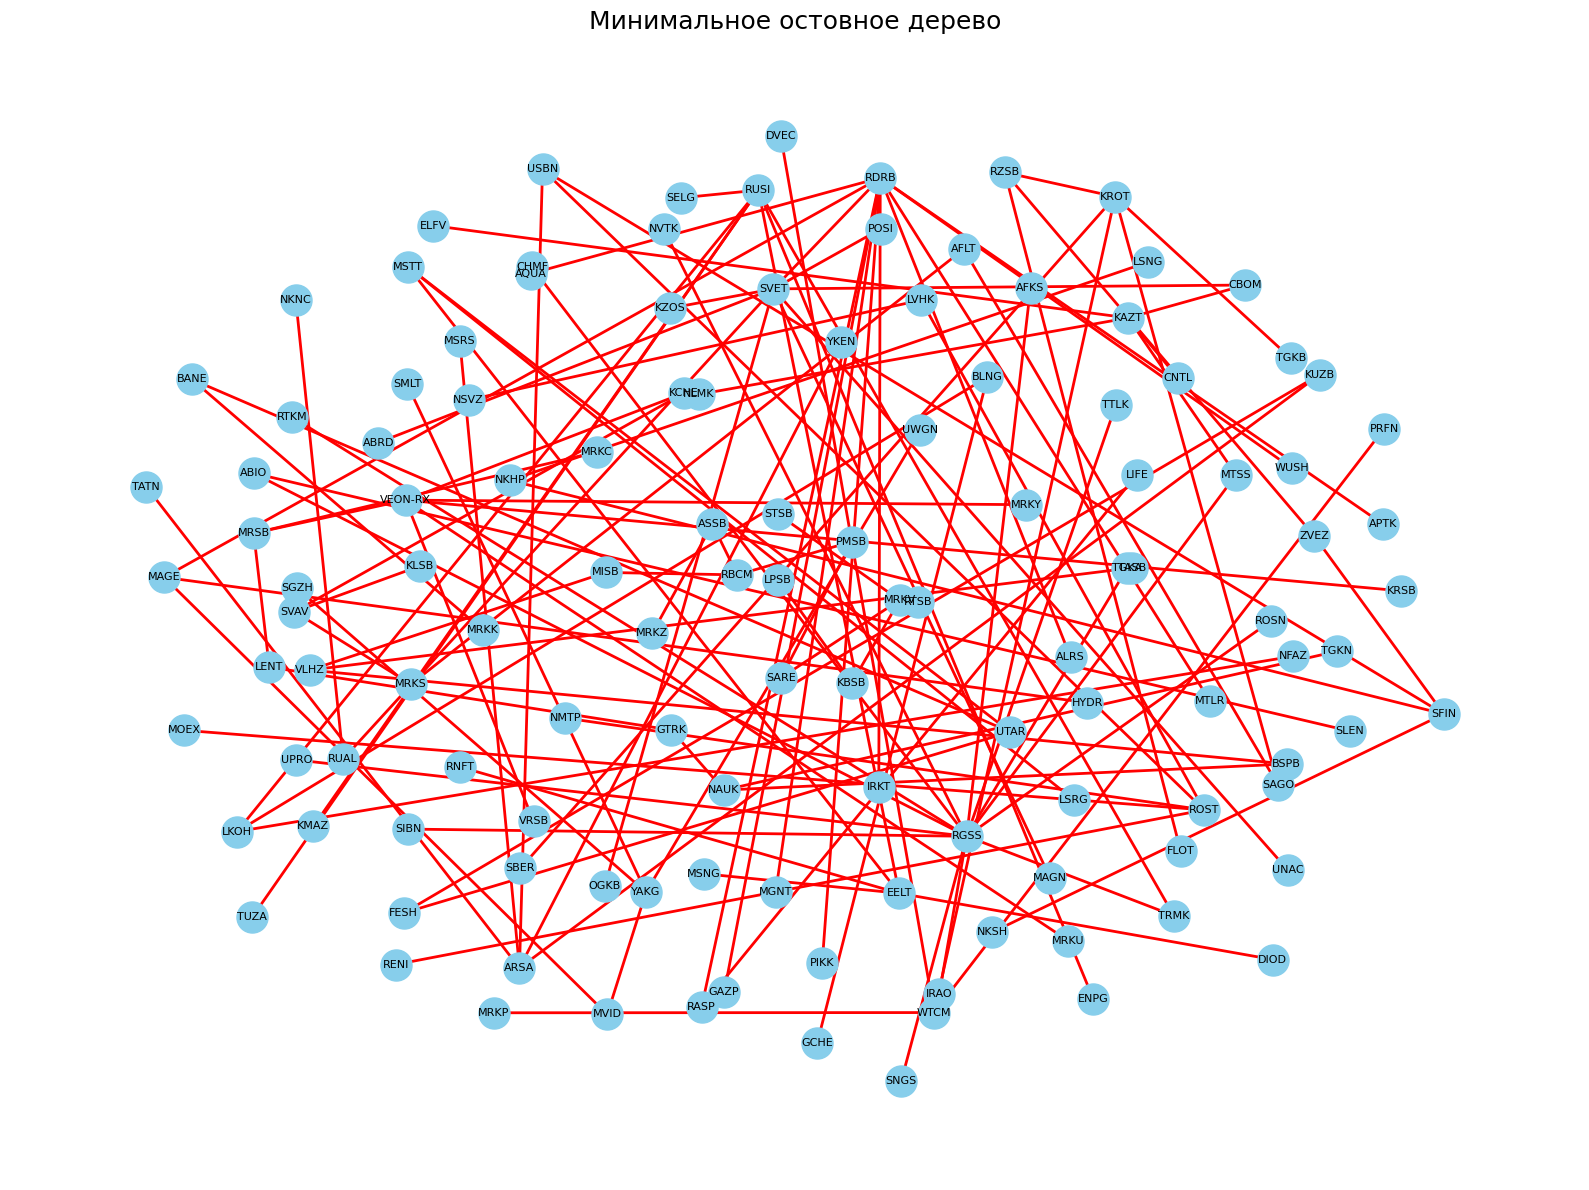

In [22]:
plt.figure(figsize=(16, 12))

nx.draw_networkx_nodes(mst, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(mst, pos, edge_color='red', width=2)
nx.draw_networkx_labels(mst, pos, font_size=8)

plt.title("Минимальное остовное дерево", fontsize=18)
plt.axis("off")
plt.tight_layout()
plt.savefig("images/picture_4.png", dpi=400)
plt.show()

In [23]:
# Среди акций берем центральные и перифирийные
# Центральные - это вершины (акции) с наибольшим количеством ребер
# Периферийные - с наименьшим

# Центральные узлы MST - это системные акции с высокой степенью связей, отражающие рынок
# Периферийные узлы - слабо связанные, с низкой корреляцией к остальным. 
# Выбор обеих групп позволяет создать диверсифицированный портфель с балансом между рыночными и диверсифицирующими активами

# Сколько топ-k выбираем центральных и top-k периферийных
TOP = 7

degrees = dict(mst.degree())

sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

central_nodes = [node for node, deg in sorted_nodes[:min(TOP, len(sorted_nodes)-1)]]
peripheral_nodes = [node for node, deg in sorted_nodes[-min(TOP, len(sorted_nodes)-1):]]
selected_stocks = central_nodes + peripheral_nodes
selected_stocks = list(set(selected_stocks))

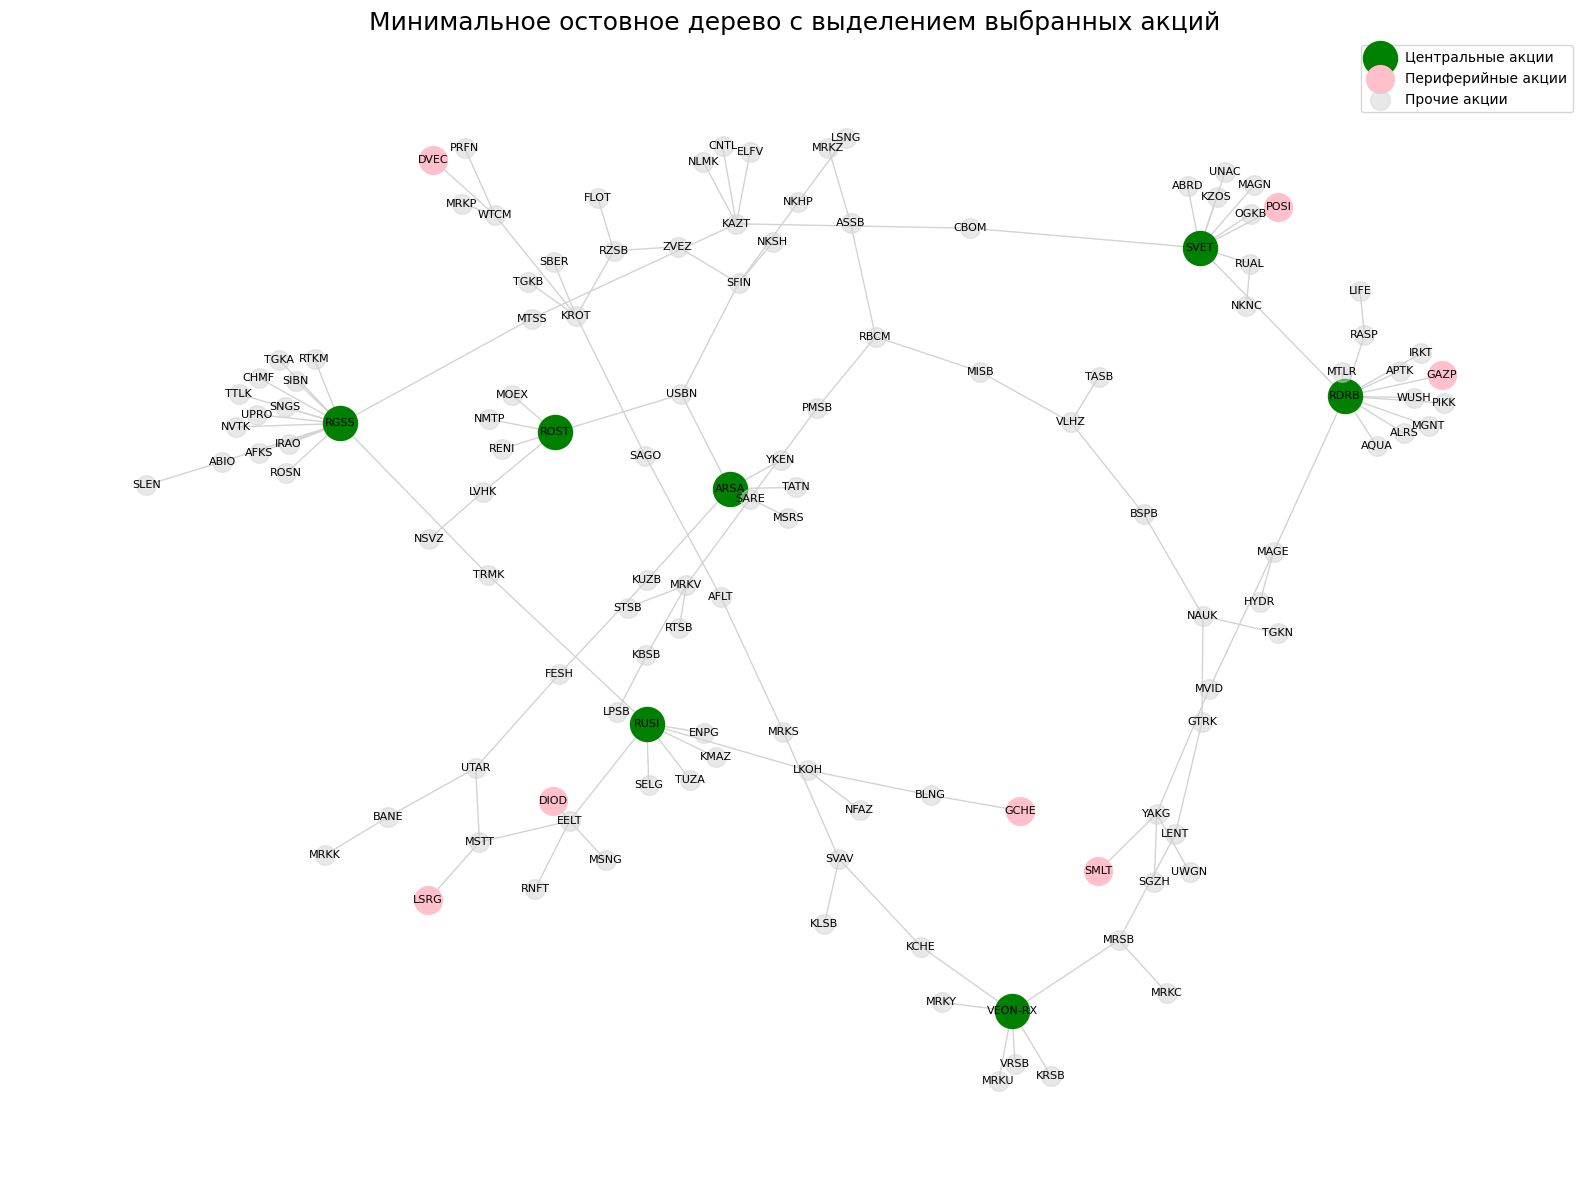

In [26]:
pos = nx.spring_layout(mst, seed=42)

plt.figure(figsize=(16, 12))

nx.draw_networkx_edges(mst, pos, edge_color='lightgray', width=1)

nx.draw_networkx_nodes(
    mst, pos,
    nodelist=central_nodes,
    node_size=600,
    node_color='green',
    label='Центральные акции'
)

nx.draw_networkx_nodes(
    mst, pos,
    nodelist=peripheral_nodes,
    node_size=400,
    node_color='pink',
    label='Периферийные акции'
)

other_nodes = list(set(mst.nodes()) - set(selected_stocks))
nx.draw_networkx_nodes(
    mst, pos,
    nodelist=other_nodes,
    node_size=200,
    node_color='lightgray',
    alpha=0.5,
    label='Прочие акции'
)

nx.draw_networkx_labels(mst, pos, font_size=8)

plt.title("Минимальное остовное дерево с выделением выбранных акций", fontsize=18)
plt.axis('off')
plt.legend(scatterpoints=1)
plt.tight_layout()
plt.savefig("images/picture_5.png", dpi=400)
plt.show()

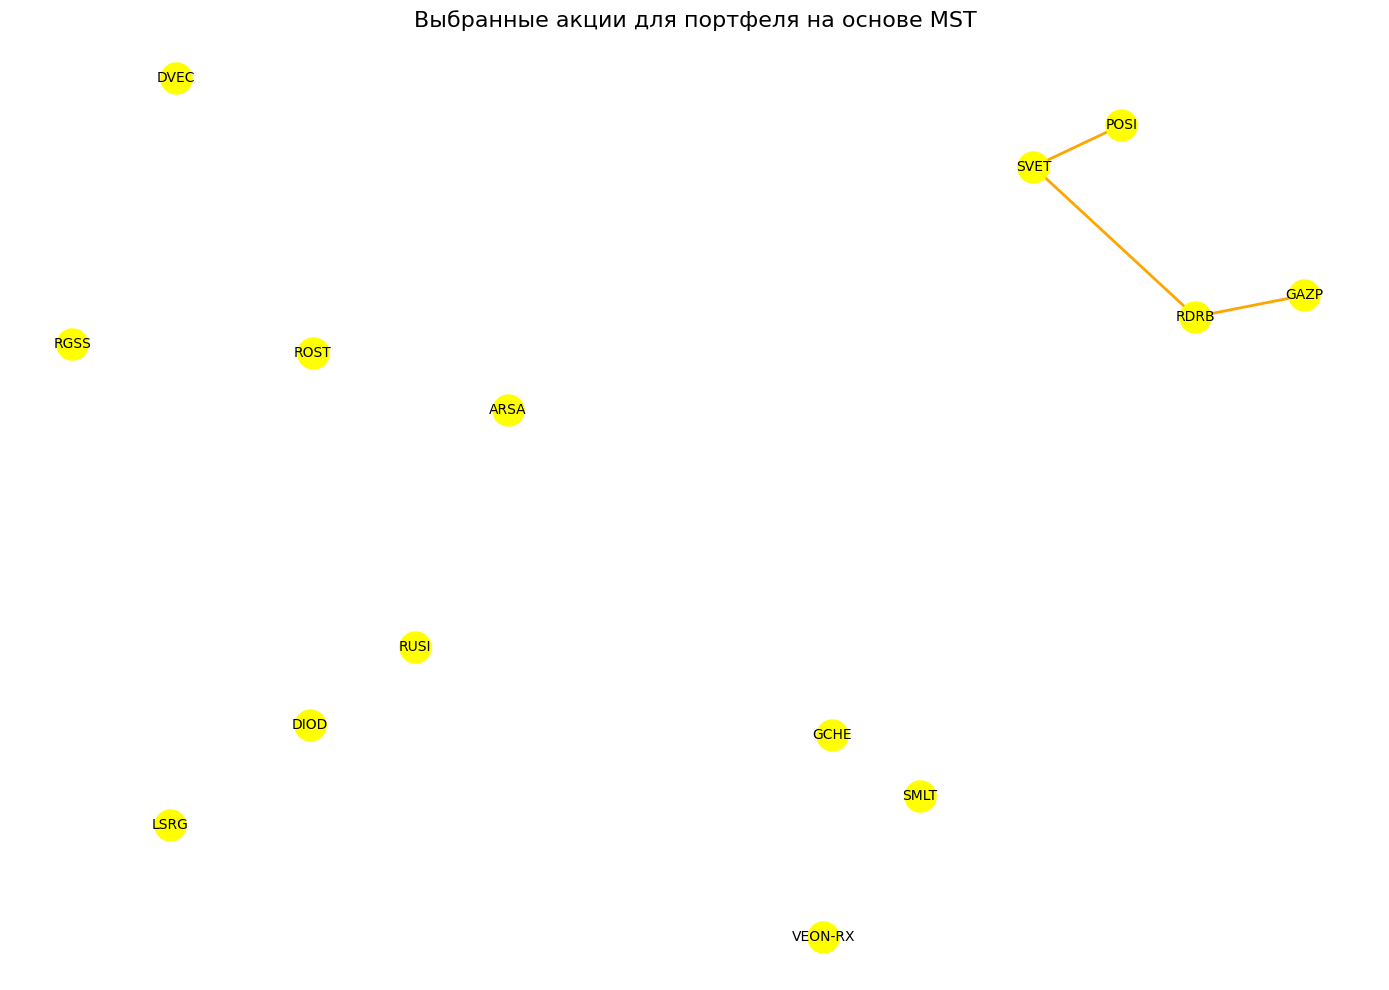

In [30]:
plt.figure(figsize=(14, 10))
subgraph = mst.subgraph(selected_stocks)

nx.draw_networkx_edges(subgraph, pos, edge_color='orange', width=2)
nx.draw_networkx_nodes(subgraph, pos, node_size=500, node_color='yellow')
nx.draw_networkx_labels(subgraph, pos, font_size=10)

plt.title("Выбранные акции для портфеля на основе MST", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig("images/picture_6.png", dpi=400)
plt.show()

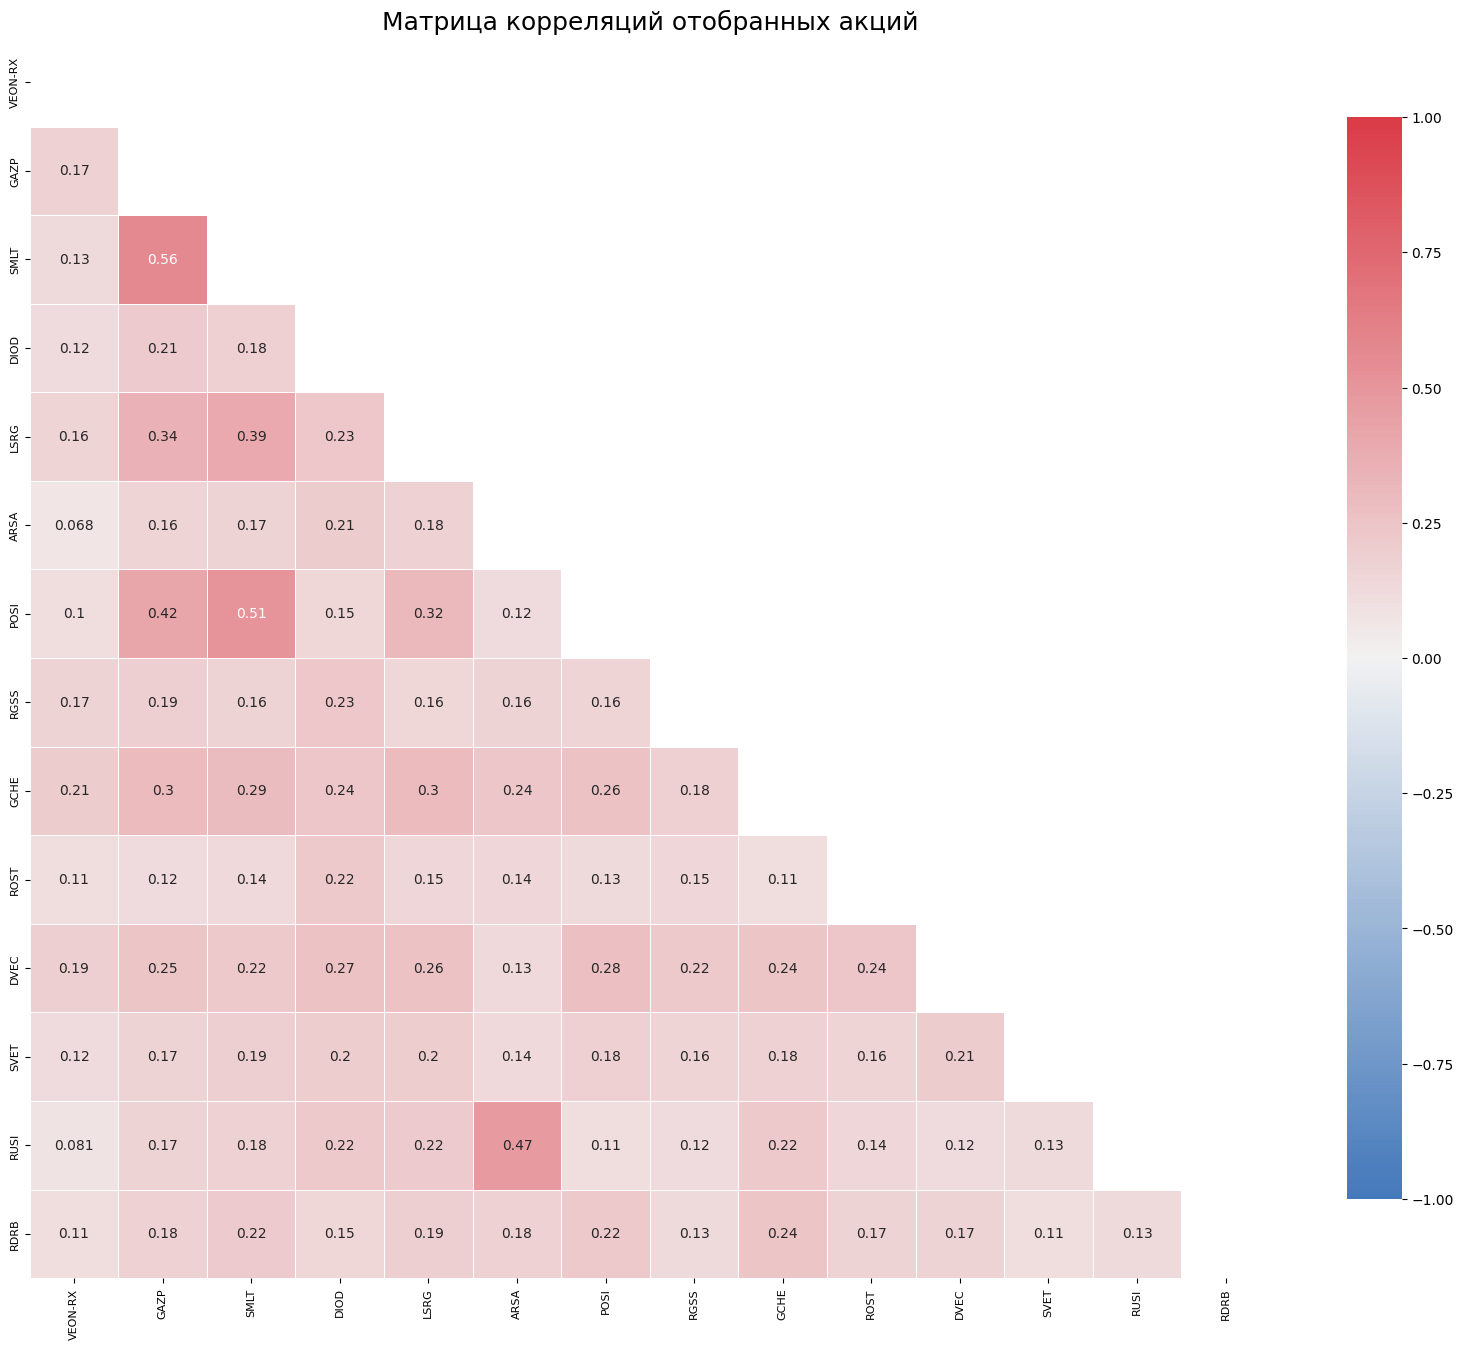

In [32]:
mask = np.triu(np.ones_like(daily_return[selected_stocks].corr(), dtype=bool))

plt.figure(figsize=(16, 14))
sns.heatmap(
    daily_return[selected_stocks].corr(),
    mask=mask,
    cmap=sns.diverging_palette(250, 10, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title("Матрица корреляций отобранных акций", fontsize=18)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig("images/picture_7.png", dpi=400)
plt.show()

In [34]:
# Вот выбранные акции

rich.print(selected_stocks)

['VEON-RX', 'GAZP', 'SMLT', 'DIOD', 'LSRG', 'ARSA', 'POSI', 'RGSS', 'GCHE', 'ROST', 'DVEC', 'SVET', 'RUSI', 'RDRB']

## 3. Составление портфеля

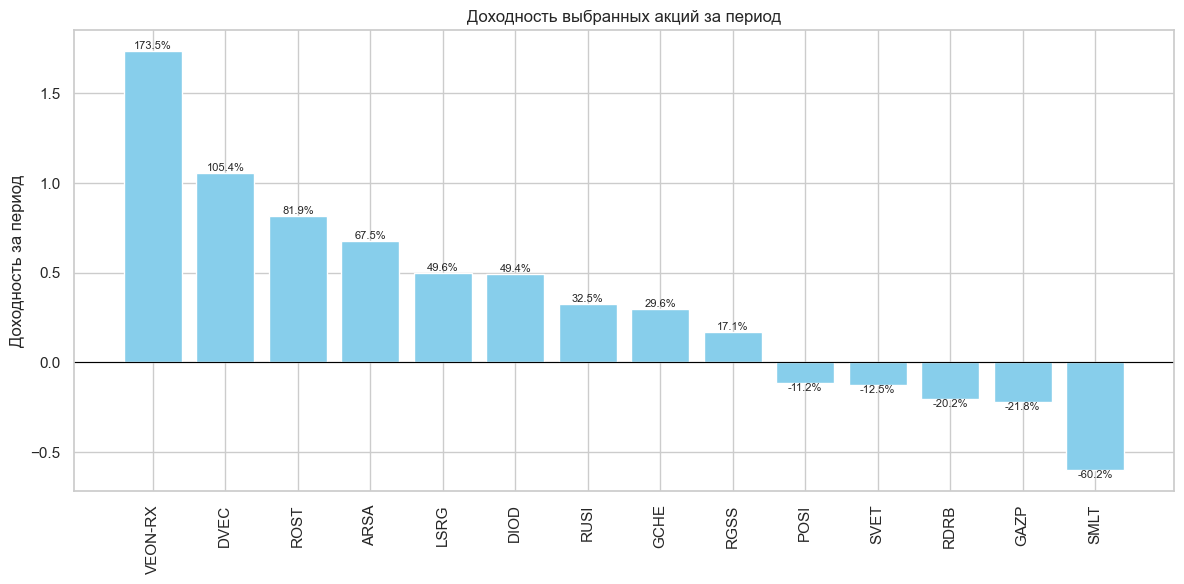

In [73]:
stocks = selected_stocks
selected_prices = df[stocks]

total_returns = (selected_prices.iloc[-1] - selected_prices.iloc[0]) / selected_prices.iloc[0]
daily_returns = selected_prices.pct_change().dropna()
cov_matrix = daily_returns.cov()

sorted_returns = total_returns.sort_values(ascending=False)

plt.figure(figsize=(12,6))
bars = plt.bar(sorted_returns.index, sorted_returns.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}',
             ha='center', va='bottom' if height >= 0 else 'top',
             fontsize=8, rotation=0)

plt.xticks(rotation=90)
plt.ylabel("Доходность за период")
plt.title("Доходность выбранных акций за период")
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig("images/picture_8.png", dpi=400)
plt.show()

**!!! ВАЖНО!!!**

Доходность выбираем исходя из [инфляции](https://calcus.ru/inflyaciya?input=eyJtb250aDEiOiIxIiwieWVhcjEiOiIyMDIzIiwibW9udGgyIjoiMiIsInllYXIyIjoiMjAyNiJ9)

Мы хотим, чтобы инфляция была меньше доходности портфеля (то есть больше 26.24%)

Рисунок с калькулятора тоже надо вставить в презу будет

In [40]:
num_stocks = len(stocks)

# Требуемая доходность
target_return = 0.3

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

constraints = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'eq', 'fun': lambda w: np.dot(w, total_returns) - target_return}
)

bounds = tuple((0,1) for _ in range(num_stocks))

init_guess = num_stocks * [1./num_stocks]

opt_result = minimize(
    portfolio_volatility, init_guess,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = opt_result.x
portfolio_allocation = dict(zip(stocks, optimal_weights))

## 4. Метрики портфеля

In [43]:
weights = optimal_weights

# Доходность портфеля
portfolio_return = np.dot(weights, total_returns[stocks])
# Риск портфеля (волатильность)
portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.loc[stocks, stocks], weights)))

print(f"Доходность портфеля: {portfolio_return:.6f}")
print(f"Риск портфеля (волатильность): {portfolio_vol:.6f}")

Доходность портфеля: 0.300000
Риск портфеля (волатильность): 0.012714


In [45]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix.loc[stocks, stocks], weights)))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for _ in range(len(stocks)))
init_guess = len(stocks) * [1./len(stocks)]

min_risk_result = minimize(portfolio_volatility, init_guess, args=(cov_matrix,), 
                           method='SLSQP', bounds=bounds, constraints=constraints)

min_risk_weights = min_risk_result.x
min_risk_return = np.dot(min_risk_weights, total_returns[stocks])
min_risk_vol = portfolio_volatility(min_risk_weights, cov_matrix)

print(f"Глобальный минимальный риск портфель:")
print(f"Доходность: {min_risk_return:.6f}, Риск: {min_risk_vol:.6f}")

Глобальный минимальный риск портфель:
Доходность: 0.196730, Риск: 0.012635


  0%|          | 0/100 [00:00<?, ?it/s]

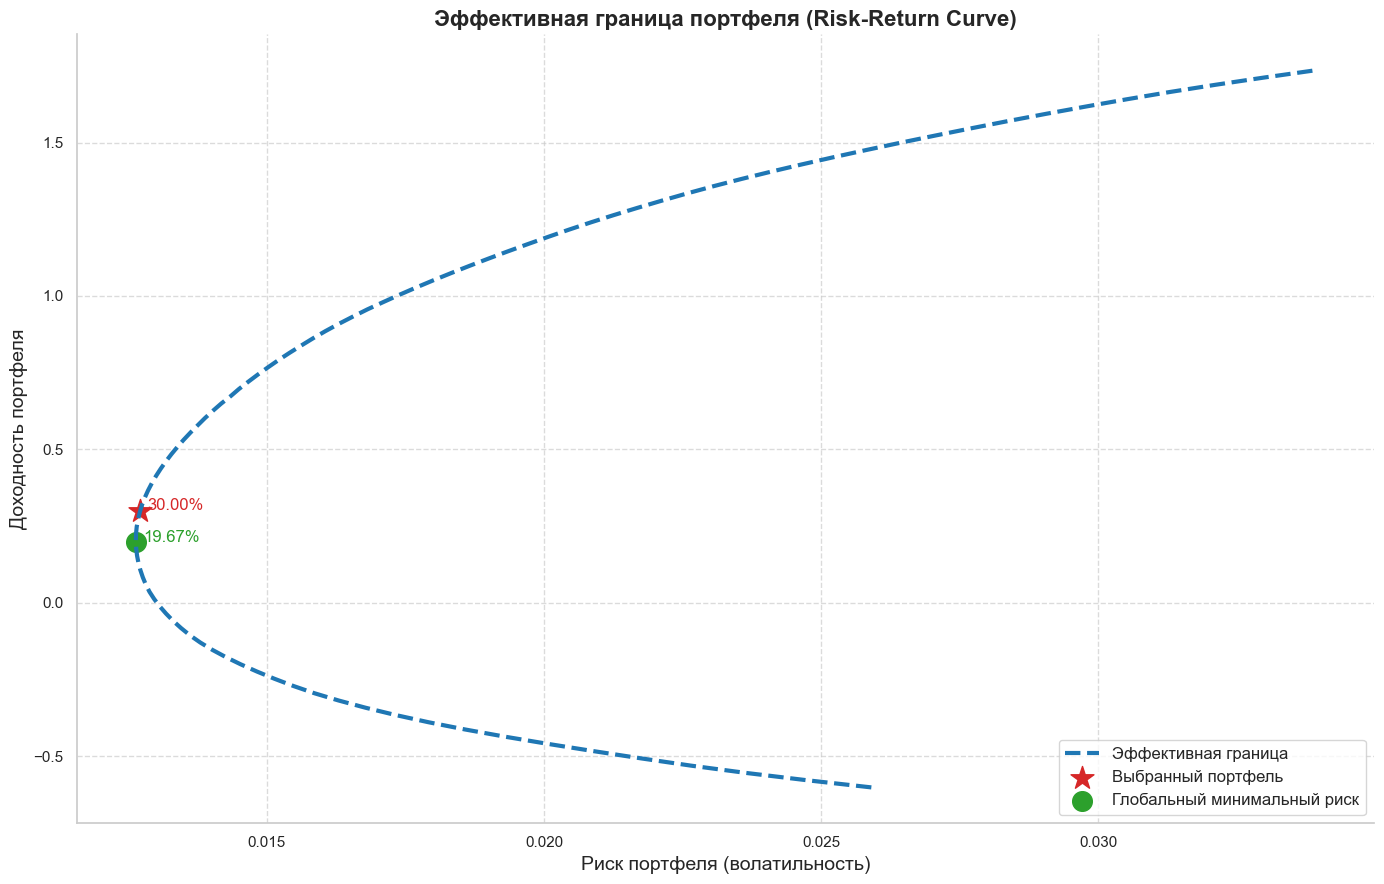

In [47]:
target_returns = np.linspace(min(total_returns[stocks]), max(total_returns[stocks]), 100)

portfolio_vols = []

for r in tqdm(target_returns):
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}, 
        {'type': 'eq', 'fun': lambda w: np.dot(w, total_returns[stocks]) - r}
    )
    result = minimize(portfolio_volatility, init_guess, args=(cov_matrix,), 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        portfolio_vols.append(result.fun)
    else:
        portfolio_vols.append(np.nan)

sns.set(style="whitegrid")

frontier_color = "#1f77b4"
selected_portfolio_color = "#d62728"
min_risk_color = "#2ca02c"

plt.figure(figsize=(14,9))

plt.plot(portfolio_vols, target_returns, linestyle='--', color=frontier_color, linewidth=3, label='Эффективная граница')

plt.scatter(portfolio_vol, portfolio_return, c=selected_portfolio_color, marker='*', s=300, label='Выбранный портфель')
plt.text(portfolio_vol*1.01, portfolio_return*1.01, f"{portfolio_return:.2%}", fontsize=12, color=selected_portfolio_color)

plt.scatter(min_risk_vol, min_risk_return, c=min_risk_color, marker='o', s=200, label='Глобальный минимальный риск')
plt.text(min_risk_vol*1.01, min_risk_return*1.01, f"{min_risk_return:.2%}", fontsize=12, color=min_risk_color)

plt.xlabel("Риск портфеля (волатильность)", fontsize=14)
plt.ylabel("Доходность портфеля", fontsize=14)
plt.title("Эффективная граница портфеля (Risk-Return Curve)", fontsize=16, weight='bold')

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='lower right')
sns.despine()
plt.tight_layout()
plt.savefig("images/picture_10.png", dpi=400)
plt.show()

In [49]:
marginal_risk = weights * np.dot(cov_matrix.loc[stocks, stocks], weights) / portfolio_vol

risk_df = pd.DataFrame({
    'Акция': stocks,
    'Доля в портфеле': weights,
    'Вклад в риск (%)': marginal_risk*100
}).sort_values(by='Вклад в риск (%)', ascending=False)

print(risk_df)

      Акция  Доля в портфеле  Вклад в риск (%)
8      GCHE     2.336024e-01      2.924716e-01
1      GAZP     1.609554e-01      1.922607e-01
6      POSI     1.285843e-01      1.579876e-01
0   VEON-RX     7.583124e-02      1.131322e-01
9      ROST     8.073330e-02      1.093979e-01
13     RDRB     9.143915e-02      1.087709e-01
4      LSRG     8.159824e-02      1.082138e-01
5      ARSA     6.631524e-02      8.957609e-02
7      RGSS     3.235080e-02      3.902273e-02
3      DIOD     2.649884e-02      3.430221e-02
11     SVET     2.209106e-02      2.627863e-02
2      SMLT     8.782038e-18      1.261785e-17
12     RUSI     1.084202e-19      1.488653e-19
10     DVEC     0.000000e+00      0.000000e+00


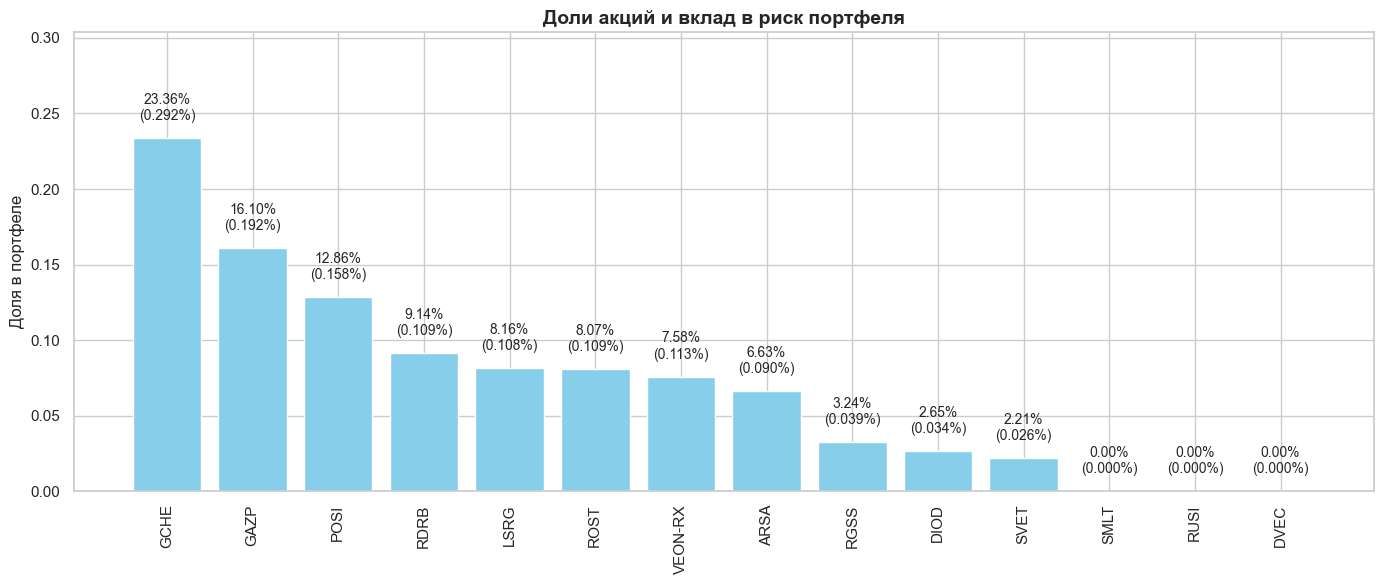

In [55]:
risk_df_sorted = risk_df.sort_values(by='Доля в портфеле', ascending=False)

plt.figure(figsize=(14,6))
bars = plt.bar(risk_df_sorted['Акция'], risk_df_sorted['Доля в портфеле'], color='skyblue')

for bar, contrib in zip(bars, risk_df_sorted['Вклад в риск (%)']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2%}\n({contrib:.3f}%)", 
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=90)
plt.ylabel("Доля в портфеле", fontsize=12)
plt.title("Доли акций и вклад в риск портфеля", fontsize=14, weight='bold')
plt.ylim(0, max(risk_df_sorted['Доля в портфеле'])*1.3)
plt.tight_layout()
plt.savefig("images/picture_11.png", dpi=400)
plt.show()

In [57]:
avg_corr = corr_matrix.loc[stocks, stocks].values[np.triu_indices(len(stocks), 1)].mean()
print(f"Средняя корреляция в портфеле: {avg_corr:.2f}")

Средняя корреляция в портфеле: 0.20


In [59]:
confidence_level = 0.05

portfolio_daily_returns = daily_returns[stocks].dot(weights)

VaR = -np.percentile(portfolio_daily_returns, confidence_level*100)
CVaR = -portfolio_daily_returns[portfolio_daily_returns <= -VaR].mean()

print(f"VaR (5%): {VaR:.2%}")
print(f"CVaR (5%): {CVaR:.2%}")

VaR (5%): 2.15%
CVaR (5%): 2.88%


In [61]:
cum_returns = (1 + portfolio_daily_returns).cumprod()

roll_max = cum_returns.cummax()
drawdown = (cum_returns - roll_max) / roll_max
max_drawdown = drawdown.min()

print(f"Максимальная просадка портфеля: {max_drawdown:.2%}")

Максимальная просадка портфеля: -34.04%


## 5. Выводы

In [64]:
portfolio_metrics = {
    'Метрика': [
        'Доходность портфеля',
        'Риск портфеля (волатильность)',
        'Средняя корреляция',
        'VaR (5%)',
        'CVaR (5%)',
        'Максимальная просадка'
    ],
    'Значение': [
        f"{portfolio_return:.6f}",
        f"{portfolio_vol:.6f}",
        f"{avg_corr:.2f}",
        f"{VaR:.6f}",
        f"{CVaR:.6f}",
        f"{max_drawdown:.6f}"
    ]
}

metrics_df = pd.DataFrame(portfolio_metrics)
print("Общие метрики портфеля:")
display(metrics_df)

risk_df_sorted_display = risk_df.sort_values(by='Доля в портфеле', ascending=False)
print("Доли акций и вклад в риск портфеля:")
display(risk_df_sorted_display)

Общие метрики портфеля:


Метрика   Значение
0            Доходность портфеля   0.300000
1  Риск портфеля (волатильность)   0.012714
2             Средняя корреляция       0.20
3                       VaR (5%)   0.021475
4                      CVaR (5%)   0.028849
5          Максимальная просадка  -0.340375

Доли акций и вклад в риск портфеля:


Акция  Доля в портфеле  Вклад в риск (%)
8      GCHE     2.336024e-01      2.924716e-01
1      GAZP     1.609554e-01      1.922607e-01
6      POSI     1.285843e-01      1.579876e-01
13     RDRB     9.143915e-02      1.087709e-01
4      LSRG     8.159824e-02      1.082138e-01
9      ROST     8.073330e-02      1.093979e-01
0   VEON-RX     7.583124e-02      1.131322e-01
5      ARSA     6.631524e-02      8.957609e-02
7      RGSS     3.235080e-02      3.902273e-02
3      DIOD     2.649884e-02      3.430221e-02
11     SVET     2.209106e-02      2.627863e-02
2      SMLT     8.782038e-18      1.261785e-17
12     RUSI     1.084202e-19      1.488653e-19
10     DVEC     0.000000e+00      0.000000e+00

**Выводы по общим метрикам портфеля:**
1) Выбранная доходность 30% за весь период (03.01.2023 - 02.02.2026), такая чтобы перекрыть инфляцию за аналогичный период
2) Волатильность ~1,27% - портфель относительно стабильный. Для такой доходности риск умеренный
3) Низкая средняя корреляция между акциями означает, что они слабо связаны между собой, что хорошо для диверсификации и уменьшения общего риска портфеля
4) Value at Risk (VaR) - это потенциальный убыток портфеля с вероятностью 5% за день. Значение 2,15% показывает, что в худший день портфель может потерять не более 2,15% с вероятностью 95%
5) Conditional Value at Risk (CVaR) - это средний убыток в худших 5% дней. В нашем портфеле ~2,88%, что показывает возможные экстремальные потери. CVaR всегда больше или равно VaR и даёт более консервативную оценку риска
6) Максимальное падение стоимости портфеля за весь период (~34%).

**Выводы по самому портфелю:**
1) Основной риск и доходность формируют GCHE, GAZP, POSI, RDRB
2) Остальные позиции служат для баланса и диверсификации
3) Некоторые акции с нулевыми долями практически не участвуют в портфеле и могут быть исключены без потери качества.